In [1]:
import sys
import os
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_nlp_pkg')
sys.path.append('C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\python_functions\\jl_model_explain_pkg')
import nlpbasic.textClean as textClean
import nlpbasic.docVectors as DocVector
import nlpbasic.dataExploration as DataExploration
import nlpbasic.lda as lda
import nlpbasic.tfidf as tfidf

import model_explain.plot as meplot
import model_explain.shap as meshap

from numpy import array,asarray,zeros
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import re
root_path = 'C:\\Users\\luoyan011\\Desktop\\PersonalLearning\\GitHub\\NLP_data'

In [6]:
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']


In [2]:
raw_data = pd.read_csv(os.path.join(root_path, "vaccination_all_tweets.csv"))

In [3]:
len(raw_data)

88978

In [52]:
data = raw_data[raw_data.text.isnull()==False]
data = data.drop_duplicates()
len(data)

88978

In [5]:
data.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False


In [53]:
data = tweet_proc(data,'text')
data['date']=pd.to_datetime(data['date'], errors='coerce').dt.date

In [8]:
i = 3
print(data.text[i])
print("-----------")
print(data.orig_text[i])

Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i 
-----------
Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4


## Vader
Apply vader and generate neg, neu, pos and compound. This dataset already have these columns, this analysis can be done in the future task. Reference: https://predictivehacks.com/how-to-run-sentiment-analysis-in-python-using-vader/

In [10]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import twitter_samples

In [54]:
vader_analyzer = SentimentIntensityAnalyzer()
vader_analyzer.polarity_scores(data.text[0])
# data['neg'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['neg'])
# data['neu'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['neu'])
# data['pos'] = data['clean_tweet'].apply(lambda x: vader_analyzer.polarity_scores(x)['pos'])
data['compound'] = data['text'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

In [55]:
data.head(3)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,orig_text,compound
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,Same folks said daikon paste could treat a cyt...,0.4019
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,While the world has been on the wrong side of ...,-0.1027
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12,Russian vaccine is created to last 2-4 y...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0.2500


## Explore and Visualization

In [56]:
data['explore_text'] = textClean.pipeline(data['text'].to_list(), multi_gram = [1], lower_case=True, deacc=False, encoding='utf8',
                                          errors='strict', stem_lemma = 'lemma', tag_drop = [], nltk_stop=True, 
                                          stop_word_list=[], 
                                          check_numbers=False, word_length=2, remove_consecutives=True)

In [57]:
i = 1
print(data.orig_text[i])
print("-----------")
print(data.text[i])
print("-----------")
print(data.explore_text[i])

While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
-----------
While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev 
-----------
['world', 'wrong', 'side', 'history', 'year', 'hopefully', 'big', 'vaccination', 'effort', 'ev']


In [58]:
pos_tweet = list(data[data['compound']>0]['explore_text'])
neg_tweet = list(data[data['compound']<0]['explore_text'])
neu_tweet = list(data[data['compound']==0]['explore_text'])

In [59]:
postop10tfidf = tfidf.get_top_n_tfidf_bow(pos_tweet, top_n_tokens = 30)
negtop10tfidf = tfidf.get_top_n_tfidf_bow(neg_tweet, top_n_tokens = 30)
neutop10tfidf = tfidf.get_top_n_tfidf_bow(neu_tweet, top_n_tokens = 30)
print('top 30 negative review tfidf', negtop10tfidf)
print('top 30 positive review tfidf', postop10tfidf)
print('top 30 neutual review tfidf', neutop10tfidf)

top 30 negative review tfidf ['end', 'trial', 'hate', 'restrict', 'propaganda', 'efficient', 'shame', 'still', 'easy', 'mind', 'doubt', 'mistake', 'mode', 'hell', 'stabbed', 'bad', 'help', 'right', 'terrible', 'ban', 'hesitate', 'stop', 'hiding', 'question', 'basic', 'disgust', 'disgrace', 'horrible', 'yes', 'care']
top 30 positive review tfidf ['vaccin', 'confident', 'celebrate', 'save', 'safety', 'safe', 'clear', 'woot', 'woohoo', 'urgent', 'want', 'responsible', 'wonderful', 'rescue', 'remember', 'confuse', 'careful', 'congrats', 'relieve', 'congratulation', 'useful', 'convince', 'cool', 'ready', 'creates', 'impressive', 'credit', 'important', 'wish', 'dear']
top 30 neutual review tfidf ['legend', 'jab', 'know', 'kick', 'boy', 'kenyan', 'keep', 'karachi', 'ka', 'jumped', 'journey', 'journal', 'joke', 'join', 'johnson', 'joe', 'jet', 'jean', 'breton', 'land', 'le', 'lead', 'book', 'local', 'board', 'body', 'load', 'living', 'live', 'listen']


In [40]:
top10_posfreq_list = DataExploration.get_topn_freq_bow(pos_tweet, topn = 10)
top10_negfreq_list = DataExploration.get_topn_freq_bow(neg_tweet, topn = 10)
print(top10_posfreq_list)
print(top10_negfreq_list)

[('vaccine', 10536), ('get', 5942), ('dose', 3367), ('covid', 3186), ('first', 2886), ('today', 2405), ('shot', 2293), ('amp', 2038), ('india', 1800), ('thank', 1741)]
[('vaccine', 4781), ('get', 2427), ('dose', 1336), ('covid', 1281), ('shot', 1197), ('ontario', 1179), ('canada', 1142), ('case', 1078), ('amp', 1075), ('first', 1002)]


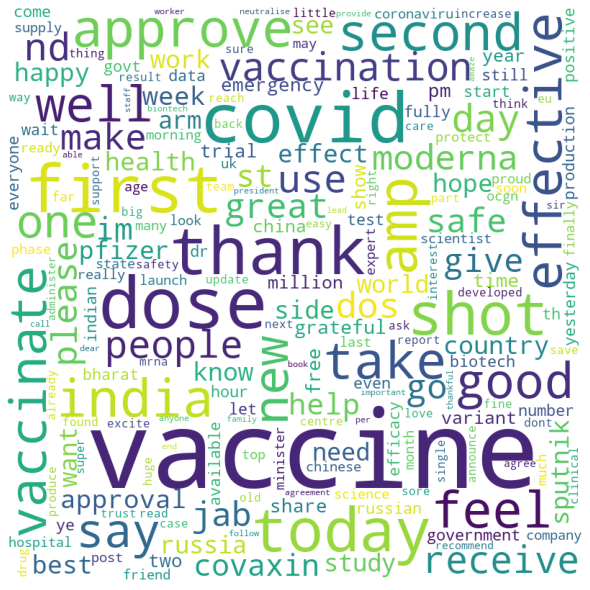

In [38]:
DataExploration.generate_word_cloud(pos_tweet)

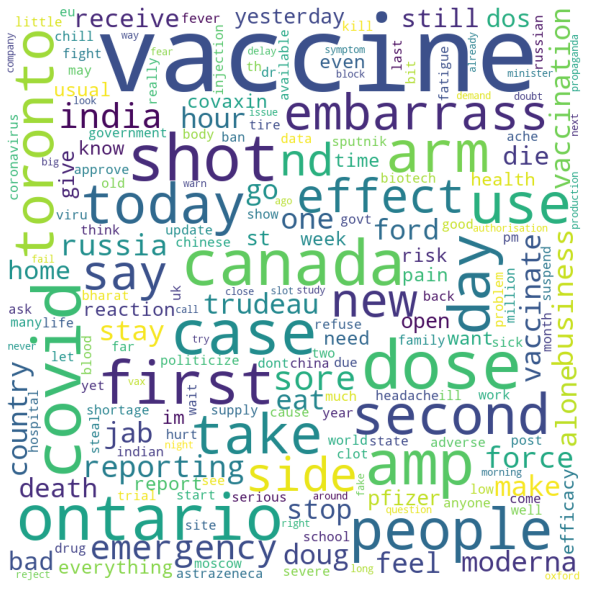

In [41]:
DataExploration.generate_word_cloud(neg_tweet)

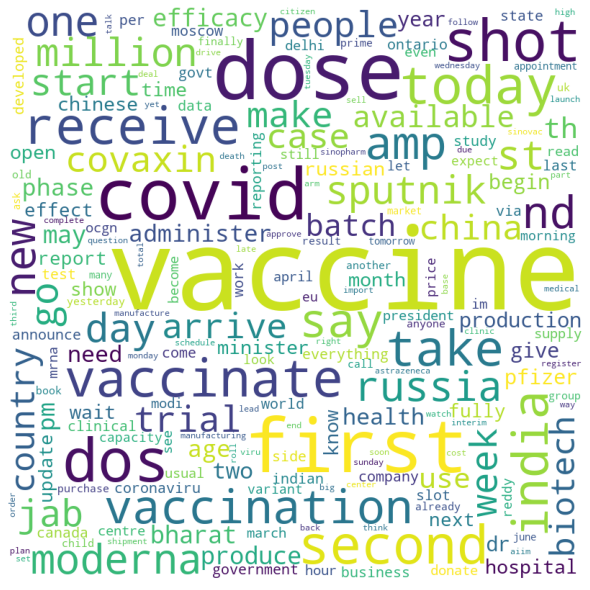

In [42]:
DataExploration.generate_word_cloud(neu_tweet)

## LDA

In [43]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(pos_tweet, num_topics = no_topics)
# lda_top30bow, bow_corpus, dictionary  = lda.fit_lda(pos_tweet, top_n_tokens = 30, num_topics = no_topics)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,get,dose,first,vaccine,today,thank,vaccinate,shot,covid,second
1,2,please,vaccine,available,well,like,vaccination,make,get,free,yes
2,3,vaccine,use,approve,biotech,bharat,emergency,covid,china,india,approval
3,4,vaccine,effective,covid,safe,study,want,variant,say,highly,get
4,5,vaccine,production,dose,june,month,hospital,covid,increase,single,get
5,6,vaccine,say,approve,india,approval,use,trial,take,good,covid
6,7,vaccine,best,news,get,people,panacea,vaccinate,dos,first,july
7,8,vaccine,india,sputnik,russia,amp,approve,good,covaxin,say,manufacturer
8,9,dos,give,vaccine,crore,number,test,positive,sir,covid,vaccination
9,10,dose,get,feel,second,well,nd,amp,vaccine,shot,first


In [44]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(neg_tweet, num_topics = no_topics)
# lda_top30bow, bow_corpus, dictionary  = lda.fit_lda(neg_tweet, top_n_tokens = 30, num_topics = no_topics)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,take,vaccine,get,people,covid,india,vaccination,reaction,amp,need
1,2,vaccine,emergency,use,delhi,get,covaxin,biotech,say,bharat,report
2,3,dose,get,day,second,first,arm,feel,vaccine,slot,shot
3,4,vaccine,get,make,dose,covid,even,bad,im,nd,vaccinate
4,5,case,ontario,canada,toronto,embarrass,reporting,politicize,business,new,stop
5,6,start,indian,go,limited,amp,covaxin,production,dose,drug,vaccine
6,7,vaccine,say,amp,country,shortage,india,covid,state,dos,indian
7,8,shot,effect,side,get,vaccine,vaccination,arm,second,covid,week
8,9,vaccine,get,people,amp,today,know,steal,covid,one,embarrass
9,10,canada,stay,force,ontario,toronto,home,alone,doug,eat,ford


## Sentiment and Emotion analysis
with result generated by fastai and fastai with transformer, we have sentiment and emotion classification, we will analyze the dataset with these 2 variable to see how's people's altitude to covid vaccine.
The code of fastai and fastai with transformer can be found in the same folder, and the code was run in Google colab with Python version 3.7

In [51]:
all_vax = ['covaxin', 'sinopharm', 'sinovac', 'moderna', 'pfizer', 'biontech', 'oxford', 'astrazeneca', 'sputnik']

# Note: a lot of the tweets seem to contain hashtags for multiple vaccines even though they are specifically referring to one vaccine - not very helpful!
def filtered_vacc(df, vax):
    df = df.dropna()
    df_filt = pd.DataFrame()
    for o in vax:
        df_filt = df_filt.append(df[df['text'].str.lower().str.contains(o)])
    other_vax = list(set(all_vax)-set(vax))
    for o in other_vax:
        df_filt = df_filt[~df_filt['text'].str.lower().str.contains(o)]
    print('vaccine ', vax, len(df_filt))
    return df_filt

covaxin = filtered_vacc(data, ['covaxin'])
sinopharm = filtered_vacc(data, ['sinopharm'])
sinovac = filtered_vacc(data, ['sinovac'])
moderna = filtered_vacc(data, ['moderna'])
pfizer = filtered_vacc(data, ['pfizer','biontech'])
oxford = filtered_vacc(data, ['oxford','astrazeneca'])
sputnik = filtered_vacc(data, ['sputnik'])

vaccine  ['covaxin'] 767
vaccine  ['sinopharm'] 157
vaccine  ['sinovac'] 155
vaccine  ['moderna'] 863
vaccine  ['pfizer', 'biontech'] 641
vaccine  ['oxford', 'astrazeneca'] 392
vaccine  ['sputnik'] 906


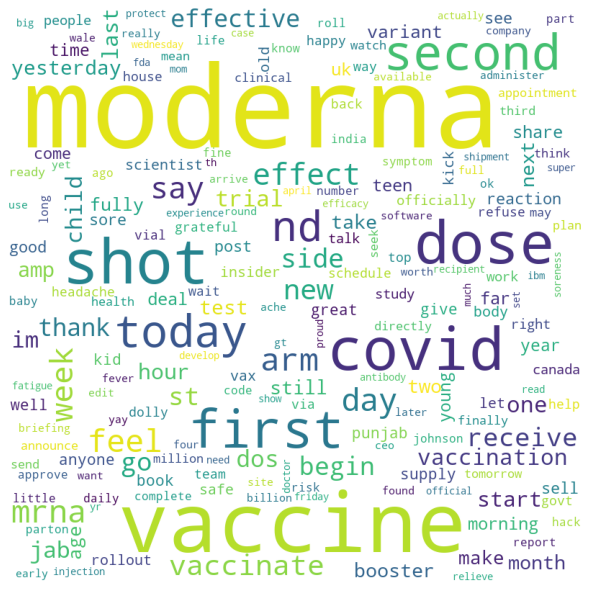

In [60]:
DataExploration.generate_word_cloud(list(moderna['explore_text']))


In [65]:
print(tfidf.get_top_n_tfidf_bow(list(moderna['explore_text']), top_n_tokens = 30))

['variant', 'body', 'risk', 'right', 'way', 'much', 'mrna', 'covid', 'make', 'vax', 'life', 'im', 'do', 'house', 'health', 'dos', 'good', 'give', 'get', 'book', 'report', 'vaccination', 'arm', 'shot', 'amp', 'today', 'anyone', 'baby', 'vaccine', 'supply']


In [67]:
no_topics = 10
lda_allbow, bow_corpus, dictionary = lda.fit_lda(list(moderna['explore_text']), num_topics = no_topics)
lda.lda_topics(lda_allbow)

,Topics,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,1,vaccine,covid,say,trial,mrna,child,begin,young,effective,test
1,2,vaccine,nd,covid,shot,get,dose,vaccination,arm,say,booster
2,3,amp,anyone,think,use,dose,start,get,test,arm,site
3,4,vaccine,covid,get,shot,st,feel,dose,first,vaccination,second
4,5,dose,get,vaccine,first,effect,side,today,do,nd,day
5,6,first,shot,get,dose,vaccine,covid,go,second,do,one
6,7,get,vaccine,today,shot,second,dose,mrna,nd,last,week
7,8,vaccine,dose,second,week,two,first,give,take,make,officially
8,9,vaccine,first,dose,get,covid,reaction,far,nd,top,good
9,10,second,shot,get,vaccine,arm,feel,dose,im,booster,hour


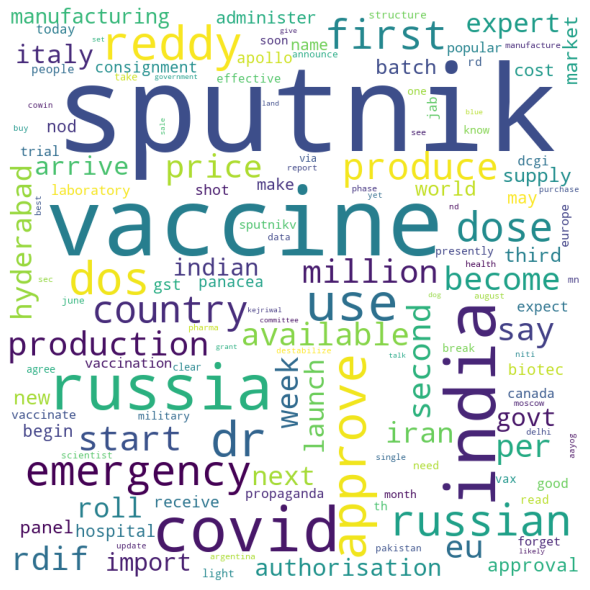

In [64]:
DataExploration.generate_word_cloud(list(sputnik['explore_text']))
